# Importing libs

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Loading data

In [2]:
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',names=['target','id','date','flag','user','text'],index_col=False)

In [3]:
data

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# Preprocessing data

In [5]:
import re
def preprocess(txt):
    regex_string = r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
    output=txt
    output=re.sub(regex_string,'',output)
    output=re.sub('(@[^\s]*)\s|\s(@[^\s]*)','',output)
    output=re.sub('(#[^\s]*)\s|\s(#[^\s]*)','',output)
    output=re.sub('[\s]{2}','',output)
    return output

In [6]:
inputs=tf.constant(data.text.map(preprocess).to_numpy())
outputs=tf.constant(data.target.replace(4,1).to_numpy())
dataset=tf.data.Dataset.from_tensor_slices((inputs,outputs))

2022-10-25 16:04:36.061746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:04:36.154264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:04:36.155300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:04:36.158709: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
tf.random.set_seed(42)

In [8]:
def dataset_split(dataset_,train_split=0.8,valid_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1600000):
    dataset_size=int(dataset_.cardinality().numpy())
    assert (train_split + valid_split + test_split) == 1
    if shuffle:
        dataset_=dataset_.shuffle(shuffle_size)
    train_size=int(dataset_size * train_split)  
    val_size = int(dataset_size * valid_split)
    train_ds = dataset_.take(train_size)    
    val_ds = dataset_.skip(train_size).take(val_size)
    test_ds = dataset_.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds 

In [9]:
train_ds,val_ds,test_ds=dataset_split(dataset)

In [10]:
train_ds=train_ds.shuffle(1600000).batch(32).prefetch(1)
val_ds=val_ds.shuffle(1600000).batch(32).prefetch(1)
test_ds=test_ds.batch(32).prefetch(1)

# Training the model

## Building the model

In [11]:
import tensorflow_hub as hub
model=keras.Sequential()
embedding_layer=hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",input_shape=[],dtype=tf.string,trainable=False)
model.add(embedding_layer)
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

2022-10-25 16:04:42.809483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
def plot_learning_curves(hist):
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

In [13]:
early_stopping=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
checkpoint=keras.callbacks.ModelCheckpoint("model.h5",save_best_only=True)
adam_optimizer=keras.optimizers.Adam(learning_rate=0.03)
model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 48,191,705
Trainable params: 1,105
Non-trainable params: 48,190,600
_________________________________________________________________


## Training the model on few epochs

In [15]:
history=model.fit(train_ds,validation_data=val_ds,callbacks=[early_stopping,checkpoint],epochs=10)

Epoch 1/10
40000/40000 [==============================] - 146s 4ms/step - loss: 0.6229 - accuracy: 0.6504 - val_loss: 0.6210 - val_accuracy: 0.6484
Epoch 2/10
40000/40000 [==============================] - 145s 4ms/step - loss: 0.6203 - accuracy: 0.6530 - val_loss: 0.6217 - val_accuracy: 0.6410
Epoch 3/10
40000/40000 [==============================] - 147s 4ms/step - loss: 0.6203 - accuracy: 0.6532 - val_loss: 0.6188 - val_accuracy: 0.6534
Epoch 4/10
40000/40000 [==============================] - 148s 4ms/step - loss: 0.6197 - accuracy: 0.6530 - val_loss: 0.6270 - val_accuracy: 0.6585
Epoch 5/10
40000/40000 [==============================] - 148s 4ms/step - loss: 0.6195 - accuracy: 0.6542 - val_loss: 0.6184 - val_accuracy: 0.6587
Epoch 6/10
40000/40000 [==============================] - 149s 4ms/step - loss: 0.6196 - accuracy: 0.6531 - val_loss: 0.6173 - val_accuracy: 0.6542
Epoch 7/10
40000/40000 [==============================] - 148s 4ms/step - loss: 0.6196 - accuracy: 0.6536 - val_

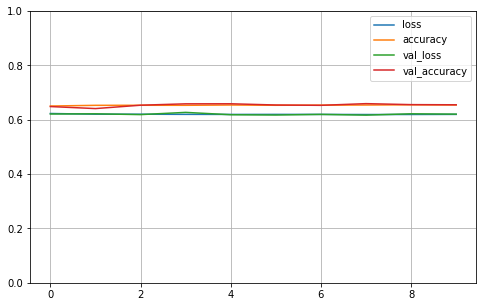

In [16]:
plot_learning_curves(history)

## Training the model on full epochs

In [17]:
for layer in model.layers:
    layer.trainable=True
adam_optimizer=keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 48,191,705
Trainable params: 48,191,705
Non-trainable params: 0
_________________________________________________________________


**The training take a large amount of time, thus we will train it on 2 epochs**

In [19]:
history=model.fit(train_ds,validation_data=val_ds,callbacks=[early_stopping,checkpoint],epochs=2)

Epoch 1/2
40000/40000 [==============================] - 665s 17ms/step - loss: 0.4788 - accuracy: 0.7695 - val_loss: 0.4371 - val_accuracy: 0.7967
Epoch 2/2
40000/40000 [==============================] - 665s 17ms/step - loss: 0.4432 - accuracy: 0.7922 - val_loss: 0.4213 - val_accuracy: 0.8064


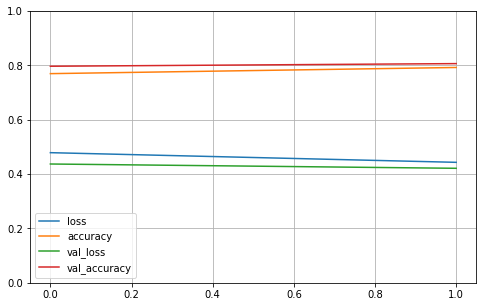

In [20]:
plot_learning_curves(history)

In [21]:
model.evaluate(test_ds)

5000/5000 [==============================] - 21s 3ms/step - loss: 0.4207 - accuracy: 0.8071


[0.42071738839149475, 0.8070687651634216]

In [22]:
model(tf.constant(['']))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.56497765]], dtype=float32)>